# GAN para generación de caras

Usamos el dataset CelebA para entrenar una red neuronal generativa antagónica para generar caras.

In [9]:
# Importa las librerias necesarias
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [10]:
# Descomprime el dataset de imagenes (En caso de hacerlo en colab)
# !unzip /content/drive/MyDrive/datasets/img_celeba_89x109.zip

In [11]:
# Verificamos que las imagenes se han extraido correctamente
data_dir = "D:\CEIABD\img_align_celeba_89x109"

if os.path.exists(data_dir):
    files = os.listdir(data_dir) # Lista con los nombres de los ficheros
    print(f"Total de imágenes: {len(files)}")
    print(f"Algunos ejemplos de imágenes: {files[:10]}")
else:
    print(f"La carpeta {data_dir} no existe.")

Total de imágenes: 202599
Algunos ejemplos de imágenes: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


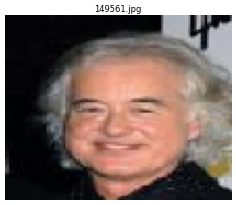

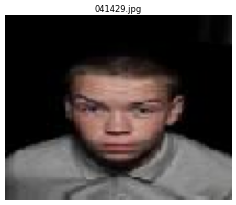

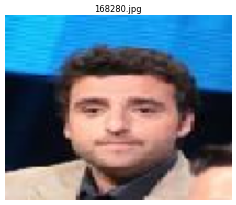

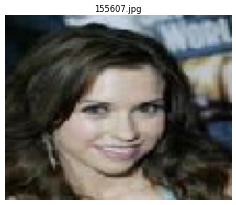

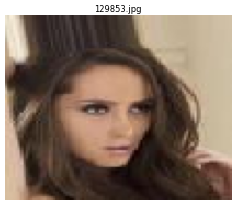

In [12]:
# Carga y muestra algunas imagenes del dataset
sample_files = random.sample(files, 5)

for file_name in sample_files:
    image_path = os.path.join(data_dir, file_name)
    image = load_img(image_path, target_size=(89, 109))
    plt.figure(dpi=50)
    plt.title(file_name)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [13]:
# Carga y procesado del dataset CelebA

# Parametros del dataset y del modelo
IMG_SIZE = (89, 109)
BATCH_SIZE = 32 # Probar mas adelante con un batch superior, valores como 64, 128, 512...
NUMBER_OF_FILES = 500

# Procesa las imagenes del dataset, lo ideal suele ser tener un rango de -1 a 1
images = []
for file_name in files[:NUMBER_OF_FILES]: # Subir a 2000, 10000, 20000... segun la disponibilidad de GPU/TPU
    image_path = os.path.join(data_dir, file_name)
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 127.5 - 1.0 # Normaliza entre -1 y 1, 127.5 * 2 = 255.0
    images.append(image)

# Convierte las imagenes a un array de numpy y prepara el dataset de TensorFlow
dataset = np.array(images)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(NUMBER_OF_FILES).batch(BATCH_SIZE)

print(f"Dataset procesado: {NUMBER_OF_FILES} imágenes cargadas y preparadas.")

Dataset procesado: 500 imágenes cargadas y preparadas.


In [14]:
# Verifica la estructura del dataset
for batch in dataset.take(1): # Toma un lote
    print("Dimensiones del lote:", batch.shape)
    print(f"Rango: ({batch.numpy().min()} a {batch.numpy().max()})")

Dimensiones del lote: (32, 89, 109, 3)
Rango: (-1.0 a 1.0)


Empezamos a crear la **GAN**.

In [15]:
# Definimos el generador 
LATENT_DIM = 100

generator = keras.Sequential([
    # Input layer
    layers.Input(shape=(LATENT_DIM,)), # Una sola dimension, por eso la coma

    # Capa inicial
    layers.Dense(6 * 7 * 512),
    # Para que los valores se mantengan, haremos normalizaciones de batch por cada capa
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # Redimension a las dimensiones iniciales
    layers.Reshape((6, 7, 512)),

    # Primera capa de convolucion
    layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Cuarta capa de convolución
    layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final de ajuste a 89x109x3
    layers.Conv2D(3, (8, 4), activation="tanh") # tanh -> Va desde -1 a 1, el rango que tenemos nosotros, probar a quitar use_bias = False
])

generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21504)          │     2,171,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21504)          │        86,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 14, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 12, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 28, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 24, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 56, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 48, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 112, 32)    │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 112, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 96, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 89, 109, 3)     │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,614,915 (25.23 MB)

 Trainable params: 6,570,947 (25.07 MB)

 Non-trainable params: 43,968 (171.75 KB)

In [16]:
# Dimensiones de cada capa
noise = tf.random.normal([1, LATENT_DIM])
x = noise

for layer in generator.layers:
    x = layer(x)
    print(f"{layer.name}: {x.shape}")

dense: (1, 21504)
batch_normalization: (1, 21504)
leaky_re_lu: (1, 21504)
reshape: (1, 6, 7, 512)
conv2d_transpose: (1, 12, 14, 256)
batch_normalization_1: (1, 12, 14, 256)
leaky_re_lu_1: (1, 12, 14, 256)
conv2d_transpose_1: (1, 24, 28, 128)
batch_normalization_2: (1, 24, 28, 128)
leaky_re_lu_2: (1, 24, 28, 128)
conv2d_transpose_2: (1, 48, 56, 64)
batch_normalization_3: (1, 48, 56, 64)
leaky_re_lu_3: (1, 48, 56, 64)
conv2d_transpose_3: (1, 96, 112, 32)
batch_normalization_4: (1, 96, 112, 32)
leaky_re_lu_4: (1, 96, 112, 32)
conv2d: (1, 89, 109, 3)


In [17]:
generated_image = generator(noise, training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 89, 109, 3)


Dimensiones de la imagen generada: (1, 89, 109, 3)
Rango de valores de la imagen generada: -0.009751013 - 0.010449236


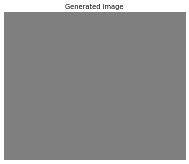

In [18]:
# Comprobacion de que el generador esta funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verificamos el rango de valores de la imagen generada
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "-", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2) # Reescala la imagen al rango [0, 1] para visualizarla 
plt.axis("off")
plt.title("Generated image")
plt.show()

In [19]:
# Definimos el discriminador
discriminator = keras.Sequential([
    # Capa de entrada
    layers.Input(shape=(89, 109, 3)),
    
    # Primera capa convolucional
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid") # Decide si la imagen es real o generada
])

In [20]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 45, 55, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 45, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 28, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 23, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        82,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,225 (1.11 MB)

 Trainable params: 292,225 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Probamos el discriminador con una imagen creada por el generador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 == Falsa, 1 == Verdadera):", decision.numpy())

Decisión del discriminador (valor cercano a 0 == Falsa, 1 == Verdadera): [[0.4999261]]


Es normal que el discriminador indique incertidumbre (valor cercano a $0.5$) porque todavía no hemos entrenado la **GAN**.

In [22]:
# Inspecciona un lote del dataset
for batch in dataset.take(1):
    print("Dimensiones del lote:", batch.shape)
    break

Dimensiones del lote: (32, 89, 109, 3)


In [23]:
# Parametros del entrenamiento
EPOCHS = 10
# Latent_DIM = 100
# BATCH_SIZE = 32 

In [24]:
# Inicializamos los optimizadores y la funcion de perdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False) # No se necesita logits porque la ultima capa que tenemos es sigmoid [0, 1]
generator_optimizer = Adam(1e-4) # Learning rate es el primer parametro
discriminator_optimizer = Adam(1e-4)

**Gradientes**: Son vectores que indican la dirección y magnitud en la que deben ajustarse los pesos de un modelo para minimizar la función de pérdida.

  0%|          | 0/10 [00:00<?, ?it/s]

Época 1/10


 10%|█         | 1/10 [00:35<05:19, 35.49s/it]

Pérdida del discriminador: 0.06110115721821785, Pérdida del generador: 4.201855659484863
Época 2/10
Pérdida del discriminador: 0.14088064432144165, Pérdida del generador: 5.057607173919678


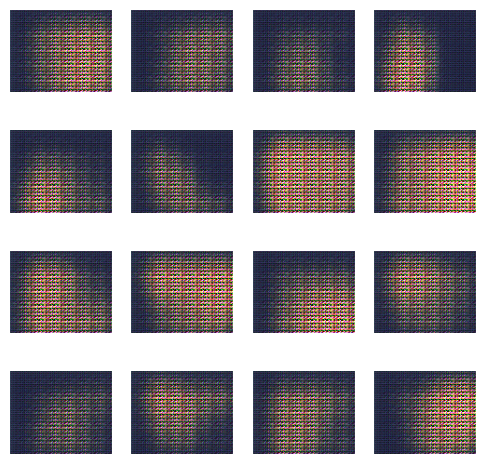

 20%|██        | 2/10 [01:09<04:35, 34.44s/it]

Época 3/10


 30%|███       | 3/10 [01:46<04:10, 35.85s/it]

Pérdida del discriminador: 0.10973265767097473, Pérdida del generador: 3.234745502471924
Época 4/10
Pérdida del discriminador: 0.31833121180534363, Pérdida del generador: 3.890110731124878


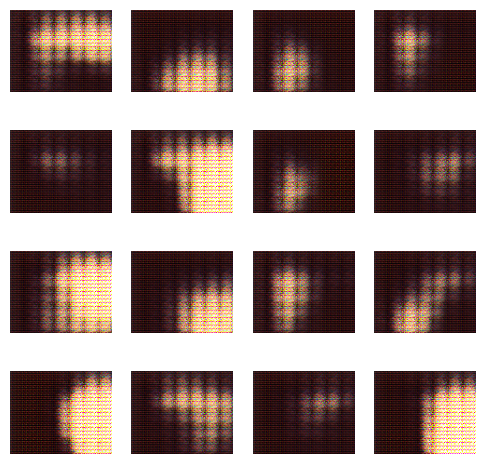

 40%|████      | 4/10 [02:19<03:27, 34.54s/it]

Época 5/10


 50%|█████     | 5/10 [03:03<03:11, 38.21s/it]

Pérdida del discriminador: 0.53095543384552, Pérdida del generador: 3.5609817504882812
Época 6/10
Pérdida del discriminador: 0.9015098810195923, Pérdida del generador: 3.8661599159240723


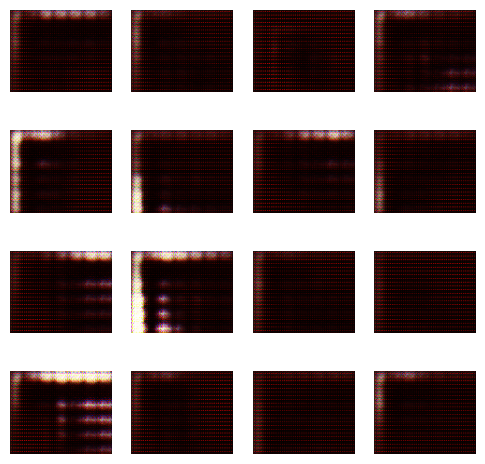

 60%|██████    | 6/10 [03:37<02:26, 36.56s/it]

Época 7/10


 70%|███████   | 7/10 [04:13<01:49, 36.51s/it]

Pérdida del discriminador: 0.6451464891433716, Pérdida del generador: 3.048128604888916
Época 8/10
Pérdida del discriminador: 0.6231573224067688, Pérdida del generador: 2.5161468982696533


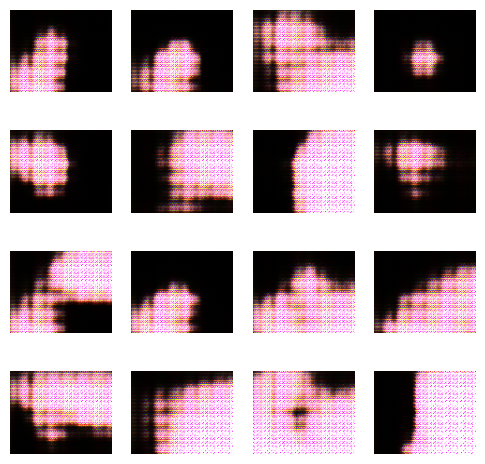

 80%|████████  | 8/10 [04:49<01:12, 36.13s/it]

Época 9/10


 90%|█████████ | 9/10 [05:26<00:36, 36.68s/it]

Pérdida del discriminador: 0.32699406147003174, Pérdida del generador: 3.212287425994873
Época 10/10
Pérdida del discriminador: 0.4349275529384613, Pérdida del generador: 3.7200818061828613


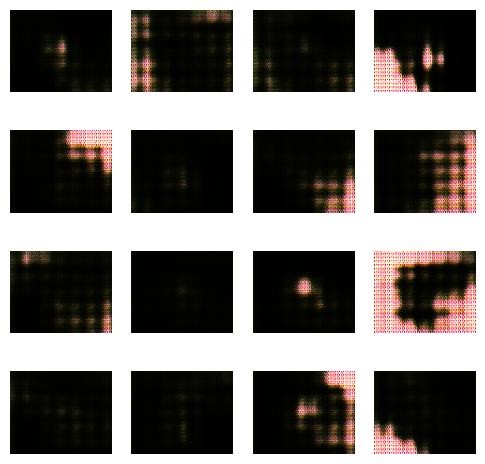

100%|██████████| 10/10 [06:04<00:00, 36.41s/it]


In [28]:
# Entrenamiento de la GAN
for epoch in tqdm(range(EPOCHS)):
    print(f"Época {epoch + 1}/{EPOCHS}...")

    for real_images in dataset: # Vamos sacando por lotes de imagenes
        # Obtenemos el tamaño del lote actual
        current_batch_size = real_images.shape[0]

        # Generamos ruido aleatorio para generar las imagenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Crearemos las imagenes falsas 
        generated_images = generator(noise, training=True)

        # Etiquetas reales y falsas
        real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
        false_labels = tf.zeros((current_batch_size, 1)) # Imágenes falsas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la perdida del discriminador
            # Obtiene las predicciones del discriminador para las imagenes reales
            real_output = discriminator(real_images, training=True)
            # Obtiene las predicciones del discriminador para las imagenes falsas
            fake_output = discriminator(generated_images, training=True)
            # Calcula la perdida del discriminador para las imagenes reales
            disc_loss_real = cross_entropy(real_labels, real_output)
            # Calcula la perdida del discriminador para las imagenes generadas (falsas)
            disc_loss_fake = cross_entropy(false_labels, fake_output)
            # Suma ambas perdiddas para obtener la perdida total del discriminador
            disc_loss = disc_loss_real + disc_loss_fake

        # Calcula los gradientes de la perdida con respecto a las variables entrenables del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del discriminador
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Genera ruido nuevamente para entrenar el generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrena el generador
        with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la perdida del generador
            # Crearemos las imagenes falsas 
            generated_images = generator(noise, training=True)
            # Evalua las imagenes generadas con el discriminador (sin actualizar los pesos)
            fake_output = discriminator(generated_images, training=False)
            # Calcula la perdida del generador intentando "engañar" al discriminador
            gen_loss = cross_entropy(real_labels, fake_output)

        # Calcula los gradientes de la perdida con respecto a las variables entrenables del generador
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del generador
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # Mostramos la perdida de cada red neuroanl (discriminador y generador)
    print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Muestra el progreso cada 2 epocas
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        # Genera y muestra imagenes de ejemplo
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]


        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img)
            ax.axis("off")
        plt.show()